In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
warnings.simplefilter("ignore")

Using TensorFlow backend.


In [5]:
features = list()
with open("/Users/hormone03/Desktop/Human_Act_Detection/UCI HAR Dataset/features.txt") as f:
    for line in f:
        features.append(line.split()[1])

In [6]:
train_df = pd.read_csv("/Users/hormone03/Desktop/Human_Act_Detection/UCI HAR Dataset/train/X_train.txt", delim_whitespace = True, names = features)

train_df["subject_id"] = pd.read_csv("/Users/hormone03/Desktop/Human_Act_Detection/UCI HAR Dataset/train/subject_train.txt", header = None, squeeze = True) #squeeze = True will 
#return data in pandas series format

train_df["activity"] = pd.read_csv("/Users/hormone03/Desktop/Human_Act_Detection/UCI HAR Dataset/train/y_train.txt", header = None, squeeze = True)

activity = pd.read_csv("/Users/hormone03/Desktop/Human_Act_Detection/UCI HAR Dataset/train/y_train.txt", header = None, squeeze = True)
#mapping activity to activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

train_df["activity_name"] = label_name

train_df.head(5)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject_id,activity,activity_name
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


In [7]:
test_df = pd.read_csv("/Users/hormone03/Desktop/Human_Act_Detection/UCI HAR Dataset/test/X_test.txt", delim_whitespace = True, names = features)

test_df["subject_id"] = pd.read_csv("/Users/hormone03/Desktop/Human_Act_Detection/UCI HAR Dataset/test/subject_test.txt", header = None, squeeze = True) #squeeze = True will 
#return data in pandas series format

test_df["activity"] = pd.read_csv("/Users/hormone03/Desktop/Human_Act_Detection/UCI HAR Dataset/test/y_test.txt", header = None, squeeze = True)

activity = pd.read_csv("/Users/hormone03/Desktop/Human_Act_Detection/UCI HAR Dataset/test/y_test.txt", header = None, squeeze = True)

#mapping activity to activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

test_df["activity_name"] = label_name

test_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject_id,activity,activity_name
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,5,STANDING


In [8]:
# Checking for nan values
print("Number of NaN values in train data is "+str(train_df.isnull().sum().sum()))
print("Number of NaN values in test data is "+str(test_df.isnull().sum().sum()))

# Checking for duplicate values
print("Number of duplicate values in train data is "+str(sum(train_df.duplicated())))
print("Number of duplicate values in test data is "+str(sum(test_df.duplicated())))

Number of NaN values in train data is 0
Number of NaN values in test data is 0
Number of duplicate values in train data is 0
Number of duplicate values in test data is 0


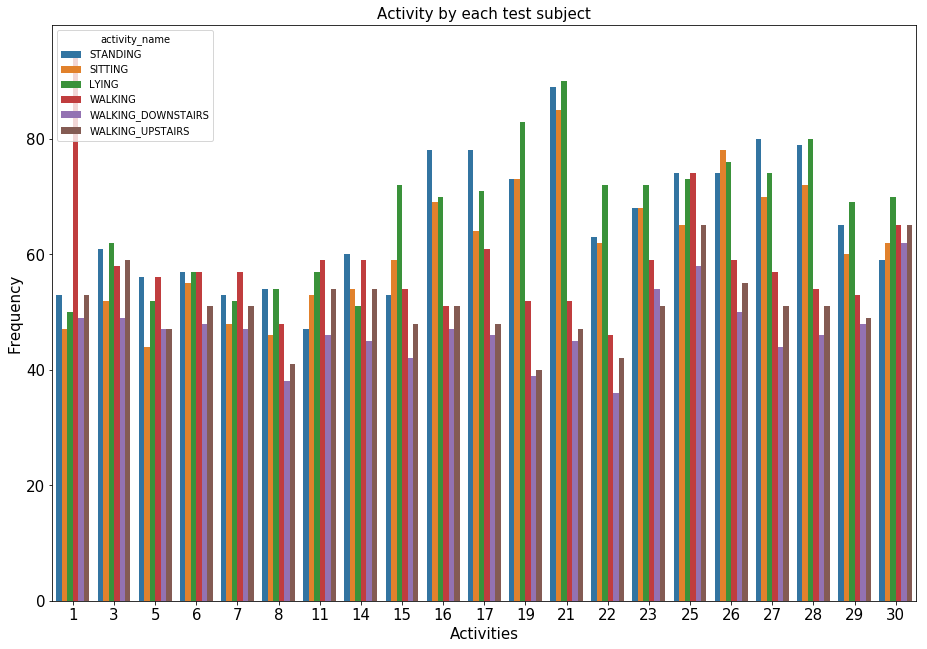

In [9]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Activity by each test subject", fontsize = 15)
plt.tick_params(labelsize = 15)
sns.countplot(x = "subject_id", hue = "activity_name", data = train_df)
plt.xlabel("Activities", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.show()

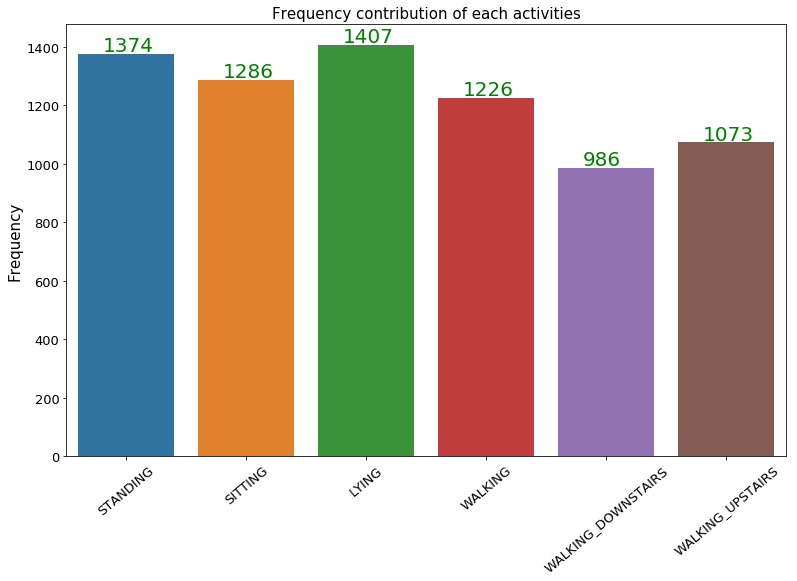

In [10]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Frequency contribution of each activities", fontsize = 15)
plt.tick_params(labelsize = 10)
sns.countplot(x = "activity_name", data = train_df)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+10, s = str(i.get_height()), fontsize = 20, color = "Green")
plt.xlabel("")
plt.ylabel("Frequency", fontsize = 15)
plt.tick_params(labelsize = 13)
plt.xticks(rotation = 40)
plt.show()

In [11]:
columns = train_df.columns

columns = columns.str.replace("[()]", '') 
columns = columns.str.replace("-", '')
columns = columns.str.replace(",", '')
#here, columns is of type pandas index. By writing "columns.str" we have changed its type to 
#pandas string. Pandas string has method called replace which we have used here.

train_df.columns = columns
test_df.columns = columns

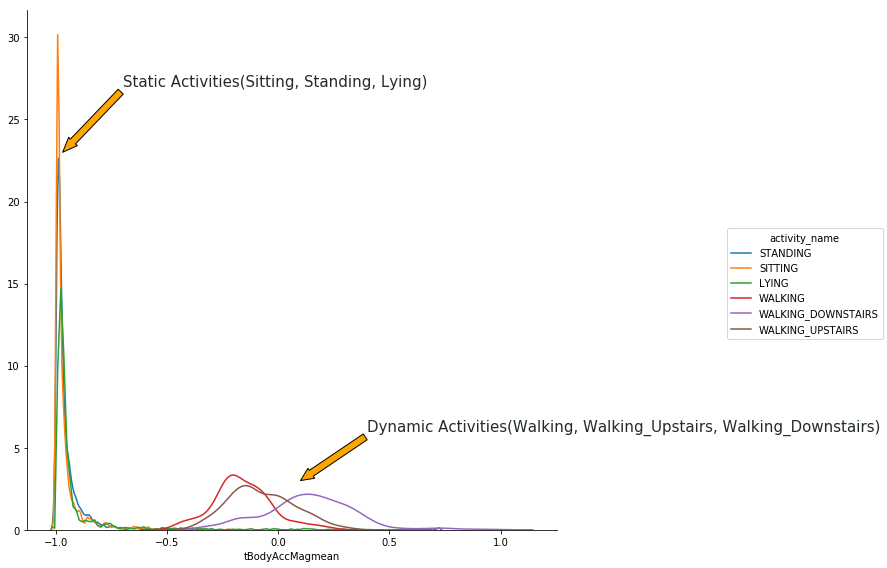

In [12]:
facetgrid = sns.FacetGrid(data = train_df, hue = "activity_name", size = 8)
facetgrid.map(sns.distplot, "tBodyAccMagmean", hist = False).add_legend()
plt.annotate('Static Activities(Sitting, Standing, Lying)', xy=(-0.97, 23), xytext=(-0.7, 27),
            arrowprops=dict(facecolor='orange', width = 7, headlength = 15), size = 15, color = "#232b2b")
plt.annotate('Dynamic Activities(Walking, Walking_Upstairs, Walking_Downstairs)', xy=(0.1, 3), xytext=(0.4, 6),
            arrowprops=dict(facecolor='orange', width = 7, headlength = 13), size = 15, color = "#232b2b")
plt.show()

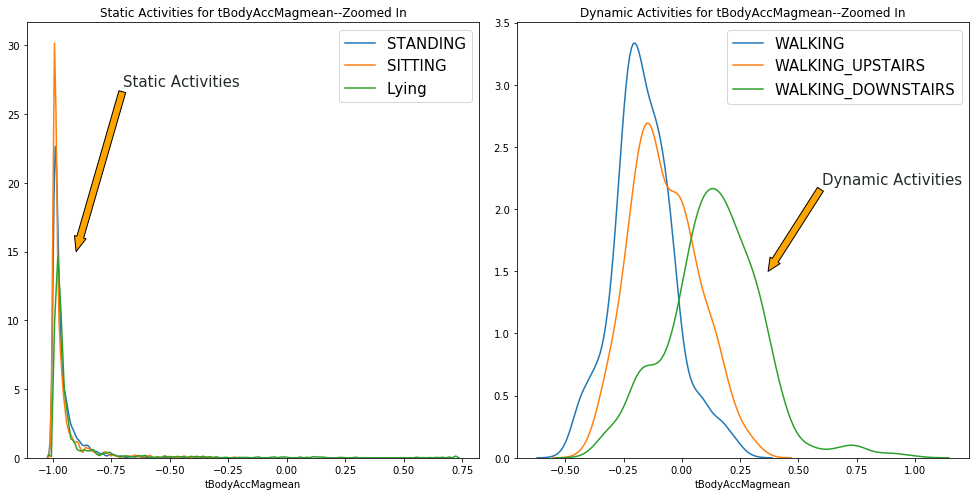

In [13]:
#let's plot "tBodyAccMagmean" for both static and dynamic activites separately to analysis them in more detail
df_standing = train_df[train_df["activity_name"] == "STANDING"]
df_sitting = train_df[train_df["activity_name"] == "SITTING"]
df_lying = train_df[train_df["activity_name"] == "LYING"]
df_walking = train_df[train_df["activity_name"] == "WALKING"]
df_walking_upstairs = train_df[train_df["activity_name"] == "WALKING_UPSTAIRS"]
df_walking_downstairs = train_df[train_df["activity_name"] == "WALKING_DOWNSTAIRS"]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 7))

axes[0].set_title("Static Activities for tBodyAccMagmean--Zoomed In")
sns.distplot(df_standing["tBodyAccMagmean"], hist = False, label = "STANDING", ax = axes[0])
sns.distplot(df_sitting["tBodyAccMagmean"], hist = False, label = "SITTING", ax = axes[0])
sns.distplot(df_lying["tBodyAccMagmean"], hist = False, label = "Lying", ax = axes[0])
axes[0].legend(fontsize = 15)
axes[0].annotate('Static Activities', xy=(-0.90, 15), xytext=(-0.7, 27),
            arrowprops=dict(facecolor='orange', width = 7, headlength = 15), size = 15, color = "#232b2b")

axes[1].set_title("Dynamic Activities for tBodyAccMagmean--Zoomed In")
sns.distplot(df_walking["tBodyAccMagmean"], hist = False, label = "WALKING", ax = axes[1])
sns.distplot(df_walking_upstairs["tBodyAccMagmean"], hist = False, label = "WALKING_UPSTAIRS", ax = axes[1])
sns.distplot(df_walking_downstairs["tBodyAccMagmean"], hist = False, label = "WALKING_DOWNSTAIRS", ax = axes[1])
axes[1].legend(fontsize = 15)
axes[1].annotate('Dynamic Activities', xy=(0.37, 1.5), xytext=(0.60, 2.2),
            arrowprops=dict(facecolor='orange', width = 7, headlength = 13), size = 15, color = "#232b2b")

plt.tight_layout()
plt.show()


In [14]:
###Observation
#From above two plots we can clearly observe that how well "tBodyAccMagmean"--which is the magnitude of the mean of body
#acceleration in time-domain meaured by accelerometer--is able to separate static activity from dynamic activity. 
#This shows that features are very carefully engineered by domian experts.


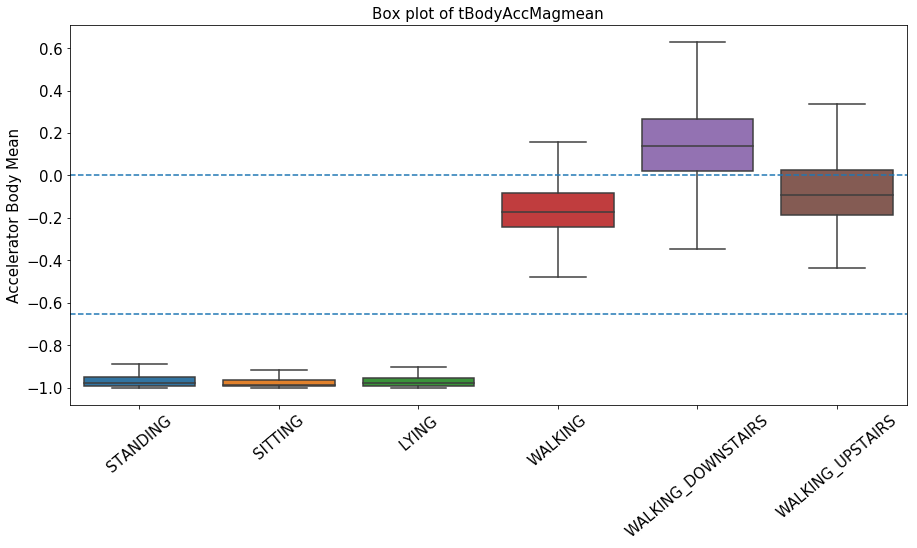

In [15]:
plt.figure(figsize = (15, 7))
sns.boxplot(x = "activity_name", y = "tBodyAccMagmean", showfliers = False, data = train_df)
plt.axhline(y = -0.65, linestyle = "--")
plt.axhline(y = 0, linestyle = "--")
plt.title("Box plot of tBodyAccMagmean", fontsize = 15)
plt.ylabel("Accelerator Body Mean", fontsize = 15)
plt.xlabel("Activity Name", fontsize = 15)
plt.xlabel("")
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

In [25]:
#Observations:

#If tAccMean is < -0.8 then the Activities are either Standing or Sitting or Laying.
#If tAccMean is > -0.6 then the Activities are either Walking or WalkingDownstairs or WalkingUpstairs.
#If tAccMean > 0.0 then the Activity is WalkingDownstairs.
#We can classify 75% the Acitivity labels with some errors.


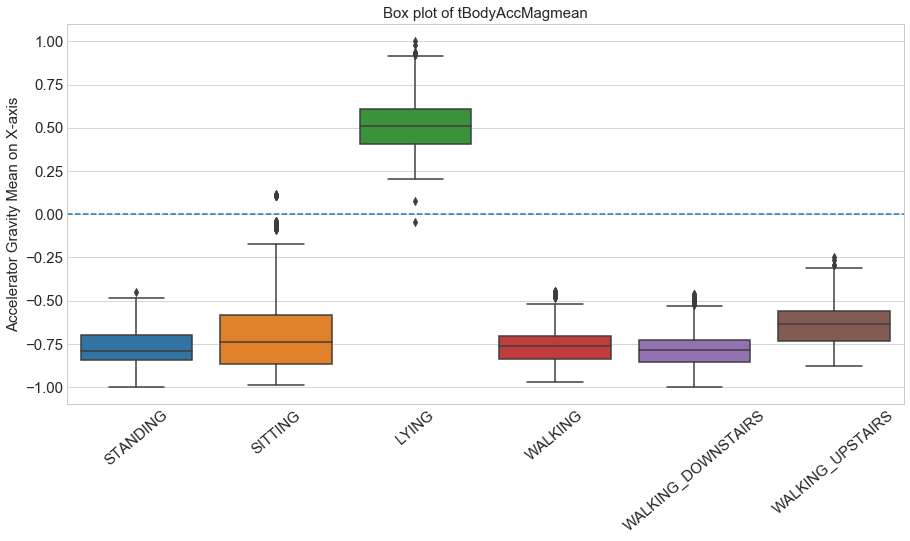

In [28]:
plt.figure(figsize = (15, 7))
sns.boxplot(x = "activity_name", y = "angleXgravityMean", showfliers = True, data = train_df)
plt.axhline(y = 0, linestyle = "--")
plt.title("Box plot of tBodyAccMagmean", fontsize = 15)
plt.ylabel("Accelerator Gravity Mean on X-axis", fontsize = 15)
plt.xlabel("")
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

In [29]:
#Observation

#If Acc Gravity Mean > 0, we can infer that the activity will most likely be Lying.
#If Acc Gravity Mean < 0, we can infer that the activity can be anything but Lying.

In [30]:
def plt_tsne(perplexity, train_df):
    data = train_df.drop(["subject_id", "activity", "activity_name"], axis = 1)
    data_label = train_df["activity_name"]
    applying_tsne = TSNE(n_components = 2, perplexity = perplexity, n_iter = 1000, verbose = 2)
    reduced_dim = applying_tsne.fit_transform(data)
    d = {'Dimension_1': applying_tsne.embedding_[:,0], 'Dimension_2': applying_tsne.embedding_[:,1], "activities":data_label}
    df = pd.DataFrame(data = d)
    print("Done...")
    print("Plotting TSNE Visualization...")
    sns.set_style('whitegrid') 
    sns.lmplot("Dimension_1", "Dimension_2", df, hue = 'activities', markers=['|','o','_', ">", "<", "^"], fit_reg = False, size = 10, scatter_kws={'s':100})
    plt.title("TSNE Plot for Perplexity "+str(perplexity))
    plt.show()
    


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.240s...
[t-SNE] Computed neighbors for 7352 samples in 27.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.961265
[t-SNE] Computed conditional probabilities in 0.046s
[t-SNE] Iteration 50: error = 114.1264191, gradient norm = 0.0220876 (50 iterations in 5.346s)
[t-SNE] Iteration 100: error = 97.8089523, gradient norm = 0.0154581 (50 iterations in 2.766s)
[t-SNE] Iteration 150: error = 93.2116699, gradient norm =

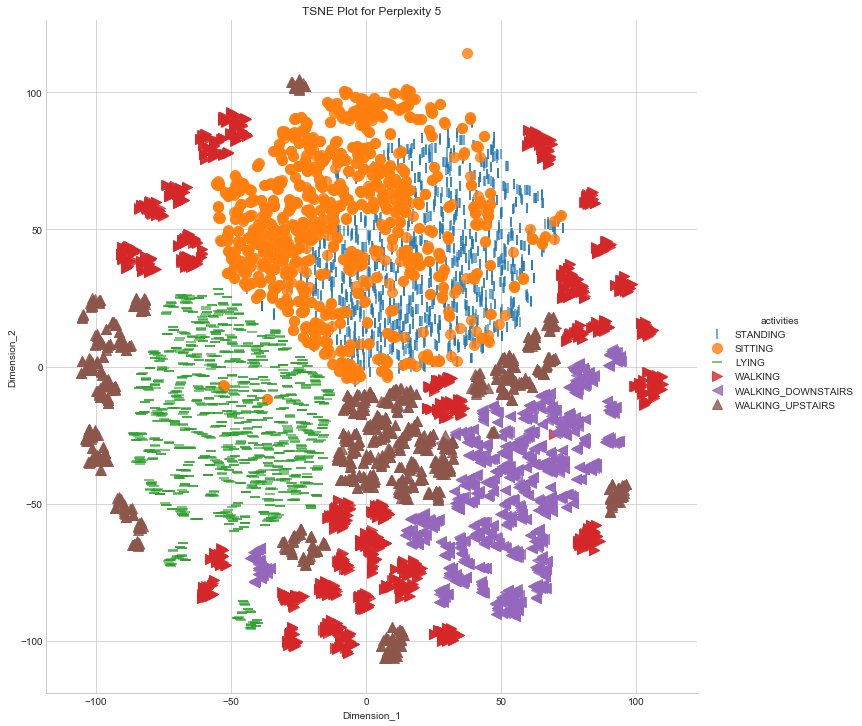

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.250s...
[t-SNE] Computed neighbors for 7352 samples in 29.558s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.133828
[t-SNE] Computed conditional probabilities in 0.079s
[t-SNE] Iteration 50: error = 105.6292343, gradient norm = 0.0196565 (50 iterations in 3.904s)
[t-SNE] Iteration 100: error = 90.3586121, gradient norm = 0.0109813 (50 iterations in 2.738s)
[t-SNE] Iteration 150: error = 87.3196106, gradient norm =

<Figure size 432x288 with 0 Axes>

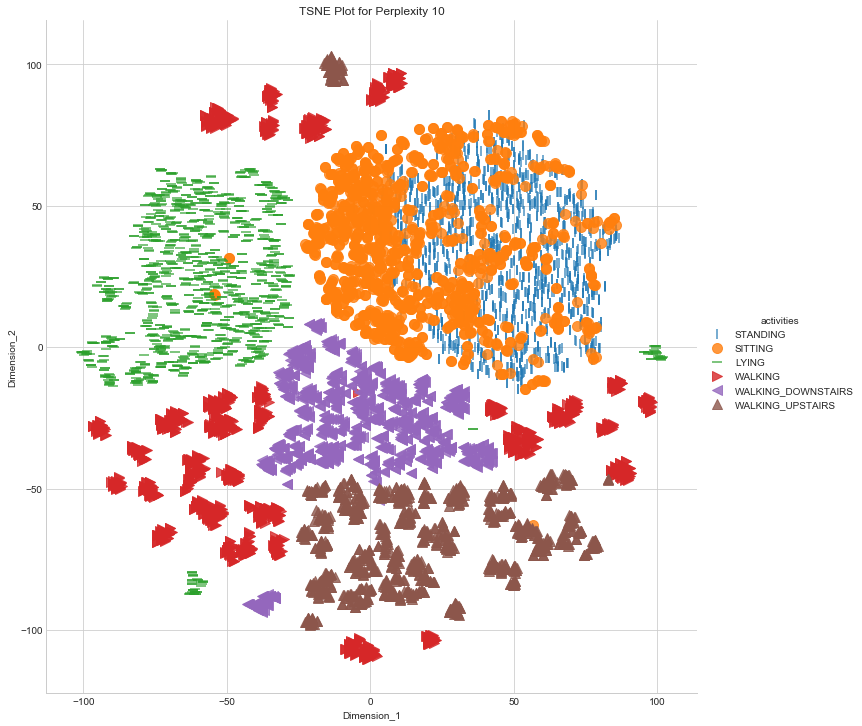

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.187s...
[t-SNE] Computed neighbors for 7352 samples in 29.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.274335
[t-SNE] Computed conditional probabilities in 0.151s
[t-SNE] Iteration 50: error = 96.6565857, gradient norm = 0.0278292 (50 iterations in 5.001s)
[t-SNE] Iteration 100: error = 84.5693436, gradient norm = 0.0071713 (50 iterations in 3.818s)
[t-SNE] Iteration 150: error = 82.3018570, gradient norm = 

<Figure size 432x288 with 0 Axes>

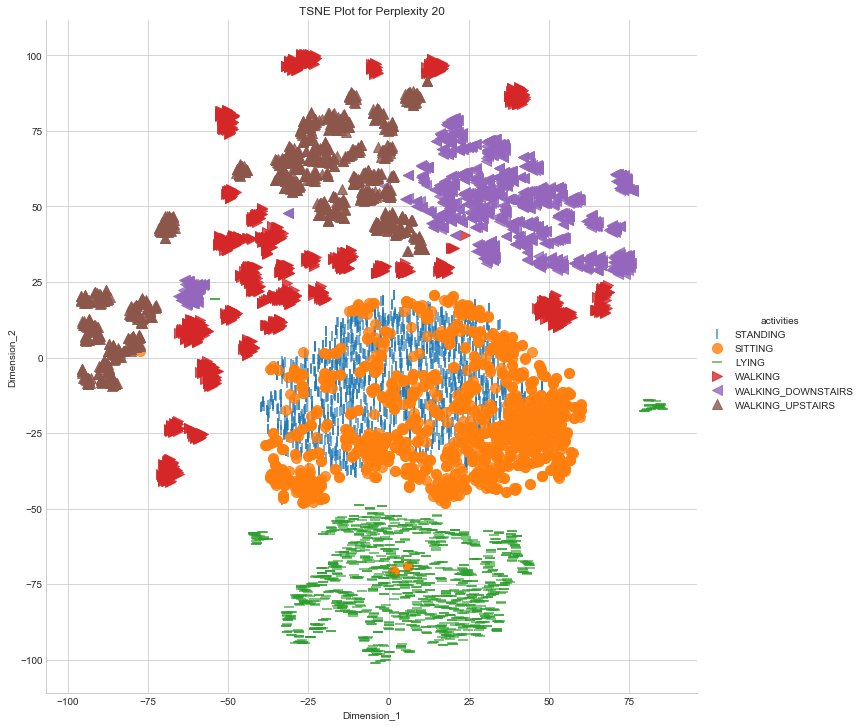

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.189s...
[t-SNE] Computed neighbors for 7352 samples in 29.882s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.399086
[t-SNE] Computed conditional probabilities in 0.334s
[t-SNE] Iteration 50: error = 89.4717865, gradient norm = 0.0171479 (50 iterations in 4.468s)
[t-SNE] Iteration 100: error = 77.7611771, gradient norm = 0.0048411 (50 iterations in 3.462s)
[t-SNE] Iteration 150: error = 76.5328751, gradient norm =

<Figure size 432x288 with 0 Axes>

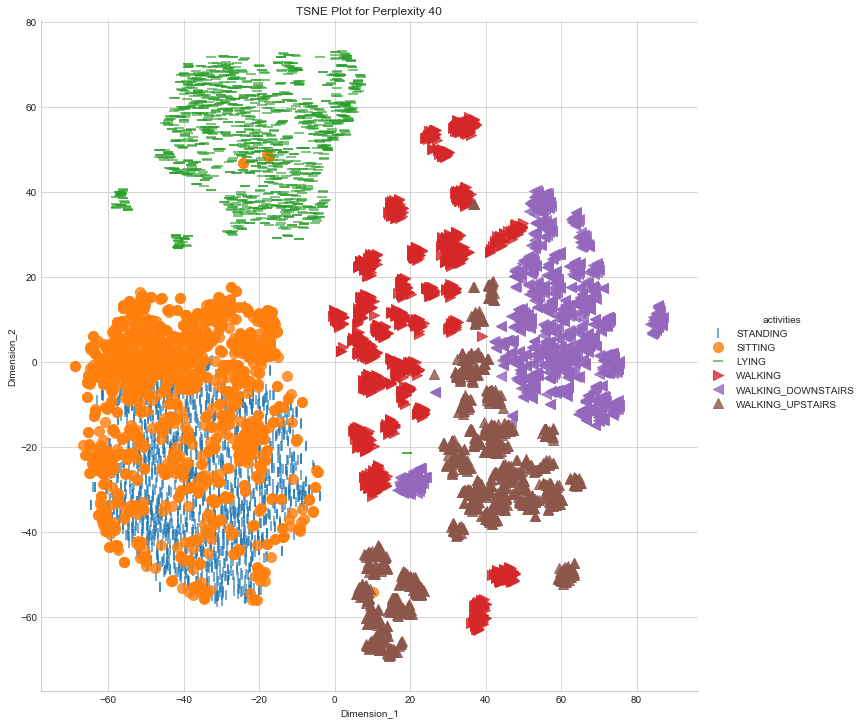

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.261s...
[t-SNE] Computed neighbors for 7352 samples in 32.379s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.559265
[t-SNE] Computed conditional probabilities in 0.754s
[t-SNE] Iteration 50: error = 78.3037796, gradient norm = 0.0130595 (50 iterations in 6.056s)
[t-SNE] Iteration 100: error = 68.2437439, gradient norm = 0.0032636 (50 iterations in 5.476s)
[t-SNE] Iteration 150: error = 67.7140503, gradient norm =

<Figure size 432x288 with 0 Axes>

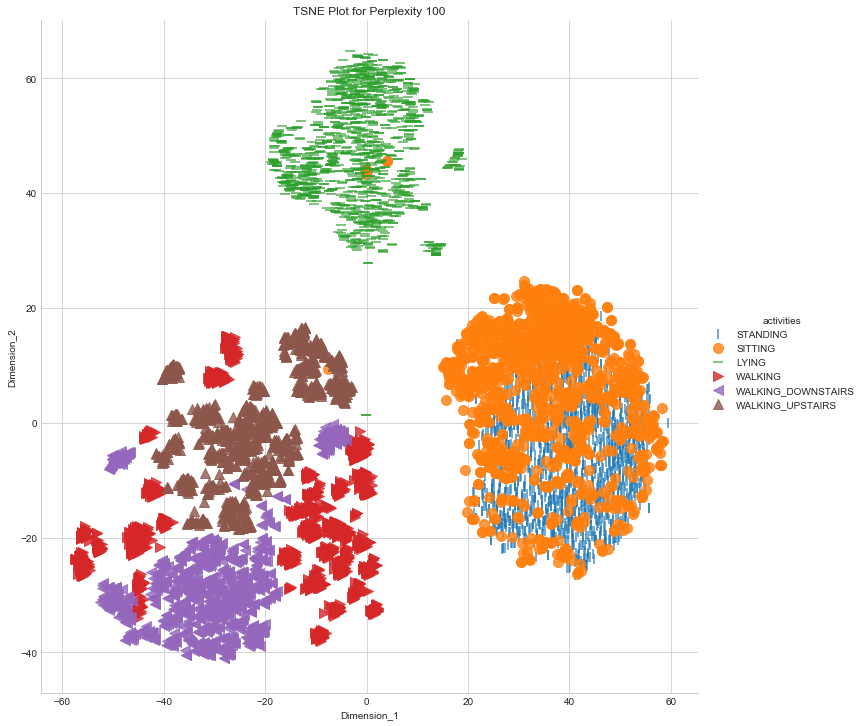

<Figure size 432x288 with 0 Axes>

In [31]:
perplexities = [5, 10, 20, 40, 100]
for perplexity in perplexities:
    plt_tsne(perplexity, train_df)
